# Predicting Exoplanet Disposition with NASA's Kepler Space Observatory Data and Machine Learning

In this notebook we apply some common machine learning classification algorithms to a set of data 
containing the details of 9,564 KOIs (Kepler Objects of Interest) to predict binary classification/disposition of KOIs as either confirmed exoplanets or false positives.

The machine learning algorithms used are:

- Logistic Regression
- Support Vector Machine
- Random Forest
- XGBoost

Each model is tuned and evaluated using the MAP (Mean Average Precision) to find which of the above algorithms are best suited for this particular binary classification problem.

### About the data
The original dataset is publicly available on the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) and contains 140 columns that are organized into the following 8 categories: Identification Columns, Exoplanet Archive Information, Project Disposition Columns, Transit Properties, Threshold-Crossing Event (TCE) Information, Stellar Parameters, KIC (Kepler Instrument Characteristic) Parameters, and Pixel-Based KOI Vetting Statistics. For the purpose of this project our aim is to predict the KOI disposition from the features in the following categories summarized below: 

| Category                                   | Description and features included in category                   |
|--------------------------------------------|-----------------------------------------------------------------|
| Transit Properties                         | Best-fit parameters produced by a [Mandel-Agol (2002)](http://adsabs.harvard.edu/abs/2002ApJ...580L.171M) fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris. __Notes:__ The two features 'koi_time0bk' and 'koi_time0' are the same measurement in different units. __Features incl.:__ 'koi_period':'koi_parm_prov'                                            |
| Threshold-Crossing Event (TCE) Information | Light curves of KOIs whose maximum folded detection statistic exceeds a specified threshold are designated as TCEs. __Features incl.:__ 'koi_max_sngle_ev':'koi_datalink_dvs'|
| Stellar Parameters                         | Parameters of the KOI's parent star. __Features incl.:__ 'koi_steff':'koi_sparprov'                                                                                     |
| KIC (Kepler Input Catalog) Parameters      | Kepler magnitudes derived from KIC photometry used to estimate (1) the degree to which each target aperture is contaminated by light from nearby sources, and (2) the fraction of source light contained in the photometric aperture compared to the total source flux. __Features incl.:__ 'ra:'koi_kmag'                                                                                                 |
| Pixel-Based KOI Vetting Statistics         | Position measurements providing an estimate of the location of the source of the transit signal when planetary transit false positives are caused by light curve contamination from an eclipsing binary falling partially within the target aperture. __Features incl.:__ 'koi_fwm_sra':'koi_dikco_msky'                                                                                 |

For more information on specific categories/features see the [offical documentation](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#tce_info).

### Summary of results

After analyzing the performance of the above classification algorithms to predict KOI disposition, XGBoost performed slightly better than Random Forest in both terms of 5-fold cross validated Mean Average Precision (MAP) (0.995) and total CPU runtime (19m 12s). XGBoost was chosen as final deployment on the testing data due to it's improved performance over Random Forest, and resulted in a MAP of 0.959 and Receiver Operating Characteristic Curve (ROC) Area Under the Curve (AUC) score of 0.996 on the testing data.

For more details, please refer to the the full analysis below as well as the final report in /reports.

## Data pre-processing

Let's import the libraries and data, and then we can start cleaning the data and analyzing it.

In [91]:
import operator
import itertools
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as ws
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [109]:
def plot_hists(df, column, c_bins=50, f_bins= 50, f_scale='linear'):
    '''
    This function Plots a histogram for each disposition (confirmed (c)/false positive (f)) 
    of a given dataframe and column.
    '''
    fig = plt.figure() # create figure
    # plt.subplots
    axc = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
    axf = fig.add_subplot(1, 2, 2)

    df_koi_train[df_koi_train['disposition'] == 'CONFIRMED'][column].plot(kind='hist', logy=True, bins=c_bins, ax=axc, 
                                                         figsize=(20,6), ec='black')
    
    axc.set_title('disposition = CONFIRMED')
    axc.set_xlabel(column)
    axc.set_ylabel('Number of KOIs')

    df_koi_train[df_koi_train['disposition'] == 'FALSE POSITIVE'][column].plot(kind='hist', logy=True, bins=f_bins, ax=axf, 
                                                              figsize=(20,6), ec='black')
    
    axf.set_xscale(f_scale)
    axf.set_title('disposition = FALSE POSITIVE')
    axf.set_xlabel(column)
    axf.set_ylabel('Number of KOIs')
    

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix (cm) and normalized confusion matrix (in parentheses)
    as calculated from sklearn.metrics.confusion_matrix().
    """
    # normalize confusion matix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # create figure
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # plot confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # plot normalized confusion matrix values
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i+.08, '(' + format(cm_norm[i, j], '.2f') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
df_koi = pd.read_csv('../data/raw/cumulative koi data.csv', skiprows=145, header=1)
df_koi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 140 entries, kepid to koi_dikco_msky_err
dtypes: float64(117), int64(6), object(17)
memory usage: 10.2+ MB


First let's take a look at the missing values as a barplot with the MissingNo library.

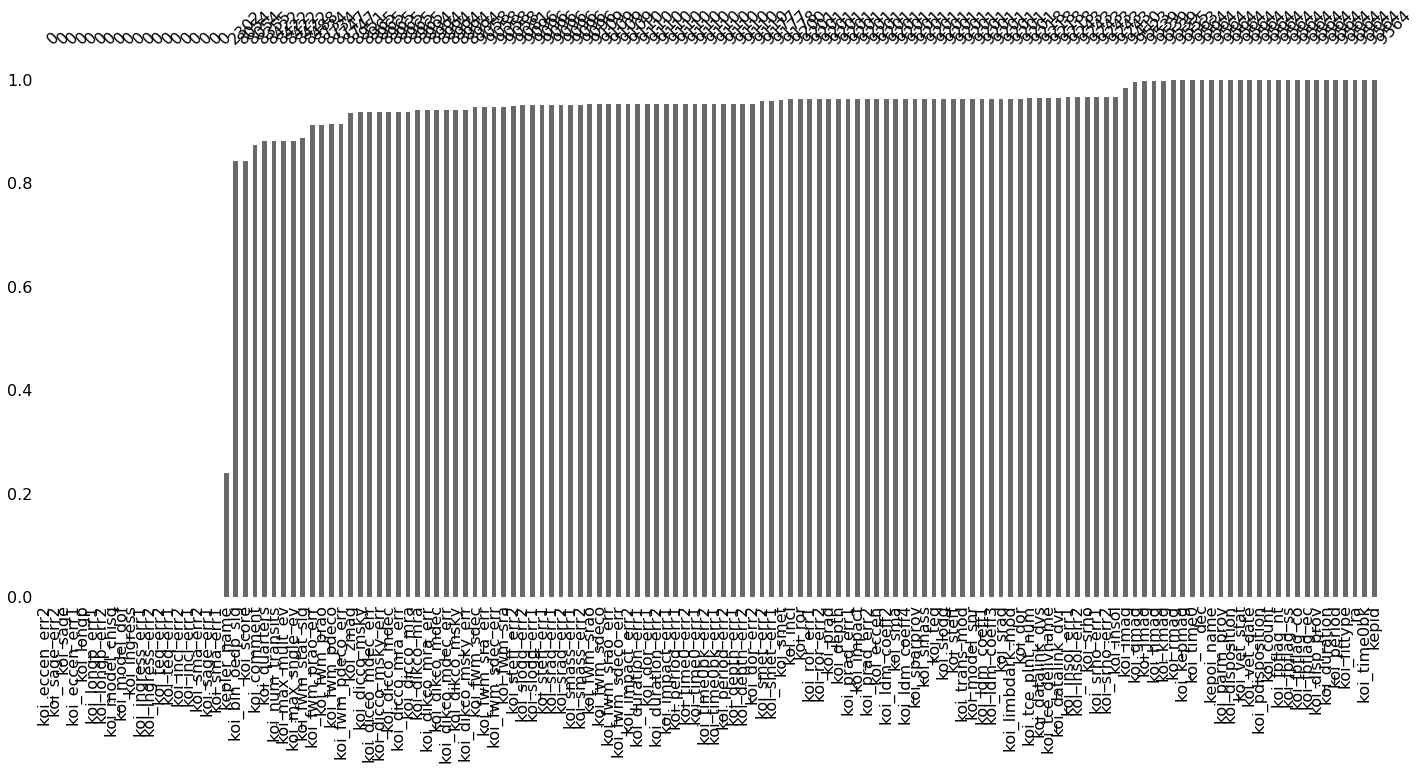

In [4]:
mn.bar(df_koi[df_koi.isnull().sum().sort_values(ascending=False).index])

Let's first remove all the columns that have all missing values and also the 'kepler_name' column since it's mostly missing values and it doesn't provide any useful info on the disposition anyways. In addition, we'll also remove the column 'koi_time0' and it's corresponding error measurements since it is the same measurement as 'koi_time0bk' just in different units.

In [5]:
# dropping columns with 0 non-null entries
nan_columns = [column for column in df_koi.columns if df_koi[column].isnull().all()]
df_koi.drop(columns=nan_columns+['kepler_name']+['koi_time0']+['koi_time0_err1']+['koi_time0_err2'],
            inplace=True)

In [6]:
pd.set_option('display.max_columns', 140)
df_koi.head()

,kepid,kepoi_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,10797460,K00752.01,CONFIRMED,Active,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,LS+MCMC,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.14191,0.000130,0.430,0.510,0.940,0.480,-0.00020,0.00032,-0.00055,0.00031,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,10797460,K00752.02,CONFIRMED,Active,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,LS+MCMC,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.14199,0.000190,-0.630,0.720,1.230,0.680,0.00066,0.00065,-0.00105,0.00063,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,10811496,K00753.01,CANDIDATE,Active,2018-08-16,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,DEEP_V_SHAPED,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,LS+MCMC,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.

Now let's shorten the names of the columns by dropping everything before the first '_' at the beginning of each column name then let's do some feature engineering to reduce/simplify the columns that describe the error on the measurement. If a numerical measurement has an upper and lower bound error associated with it (eg: columns that end with '..._err1' and '...err2'), let's turn the two columns into one column that describe the difference in the upper and lower bounds.

In [7]:
# making the column names shorter keeping only the name after the first '_'
new_columns = [x.split('_', 1)[1] if '_' in x else x for x in df_koi.columns]
df_koi.columns = new_columns

# creating new column for each error that describes the difference between the upper and lower bound errors
i=0
while i <= 90:
    if 'err1' in df_koi.columns[i]:
        new_col = df_koi[df_koi.columns[i]] - df_koi[df_koi.columns[i+1]]
        df_koi.insert(loc=i, column=df_koi.columns[i-1]+'_err', value=new_col)
        i += 3
    else:
        i += 1
        
# dropping err1 and err2 columns
df_koi.drop(columns=[column for column in df_koi.columns if 'err1' in column or 'err2' in column],
            inplace=True)

Let's go ahead check if there are any columns that contain the same entry for every KOI and then delete those columns, as they don't supply any useful info.

In [8]:
uniques = df_koi.apply(lambda x: x.nunique())

uniq_cols = len([entry for entry in uniques if entry == 1])
print('Number of columns where all entries all the exact same: {}'.format(uniq_cols))

Number of columns where all entries all the exact same: 8


In [9]:
df_koi.drop(uniques[uniques == 1].index, axis=1, inplace=True)

Let's remove all the KOIs that are dispositioned as 'CANDIDATE' since we're only interested in the two classes 'FALSE POSITIVE' and 'CONFIRMED'.

In [10]:
df_koi = df_koi[df_koi['disposition'] != 'CANDIDATE']

Let's visualize the missing values again, this time as a matrix to see if there are many rows that contain mostly missing values that we might want to get rid of.

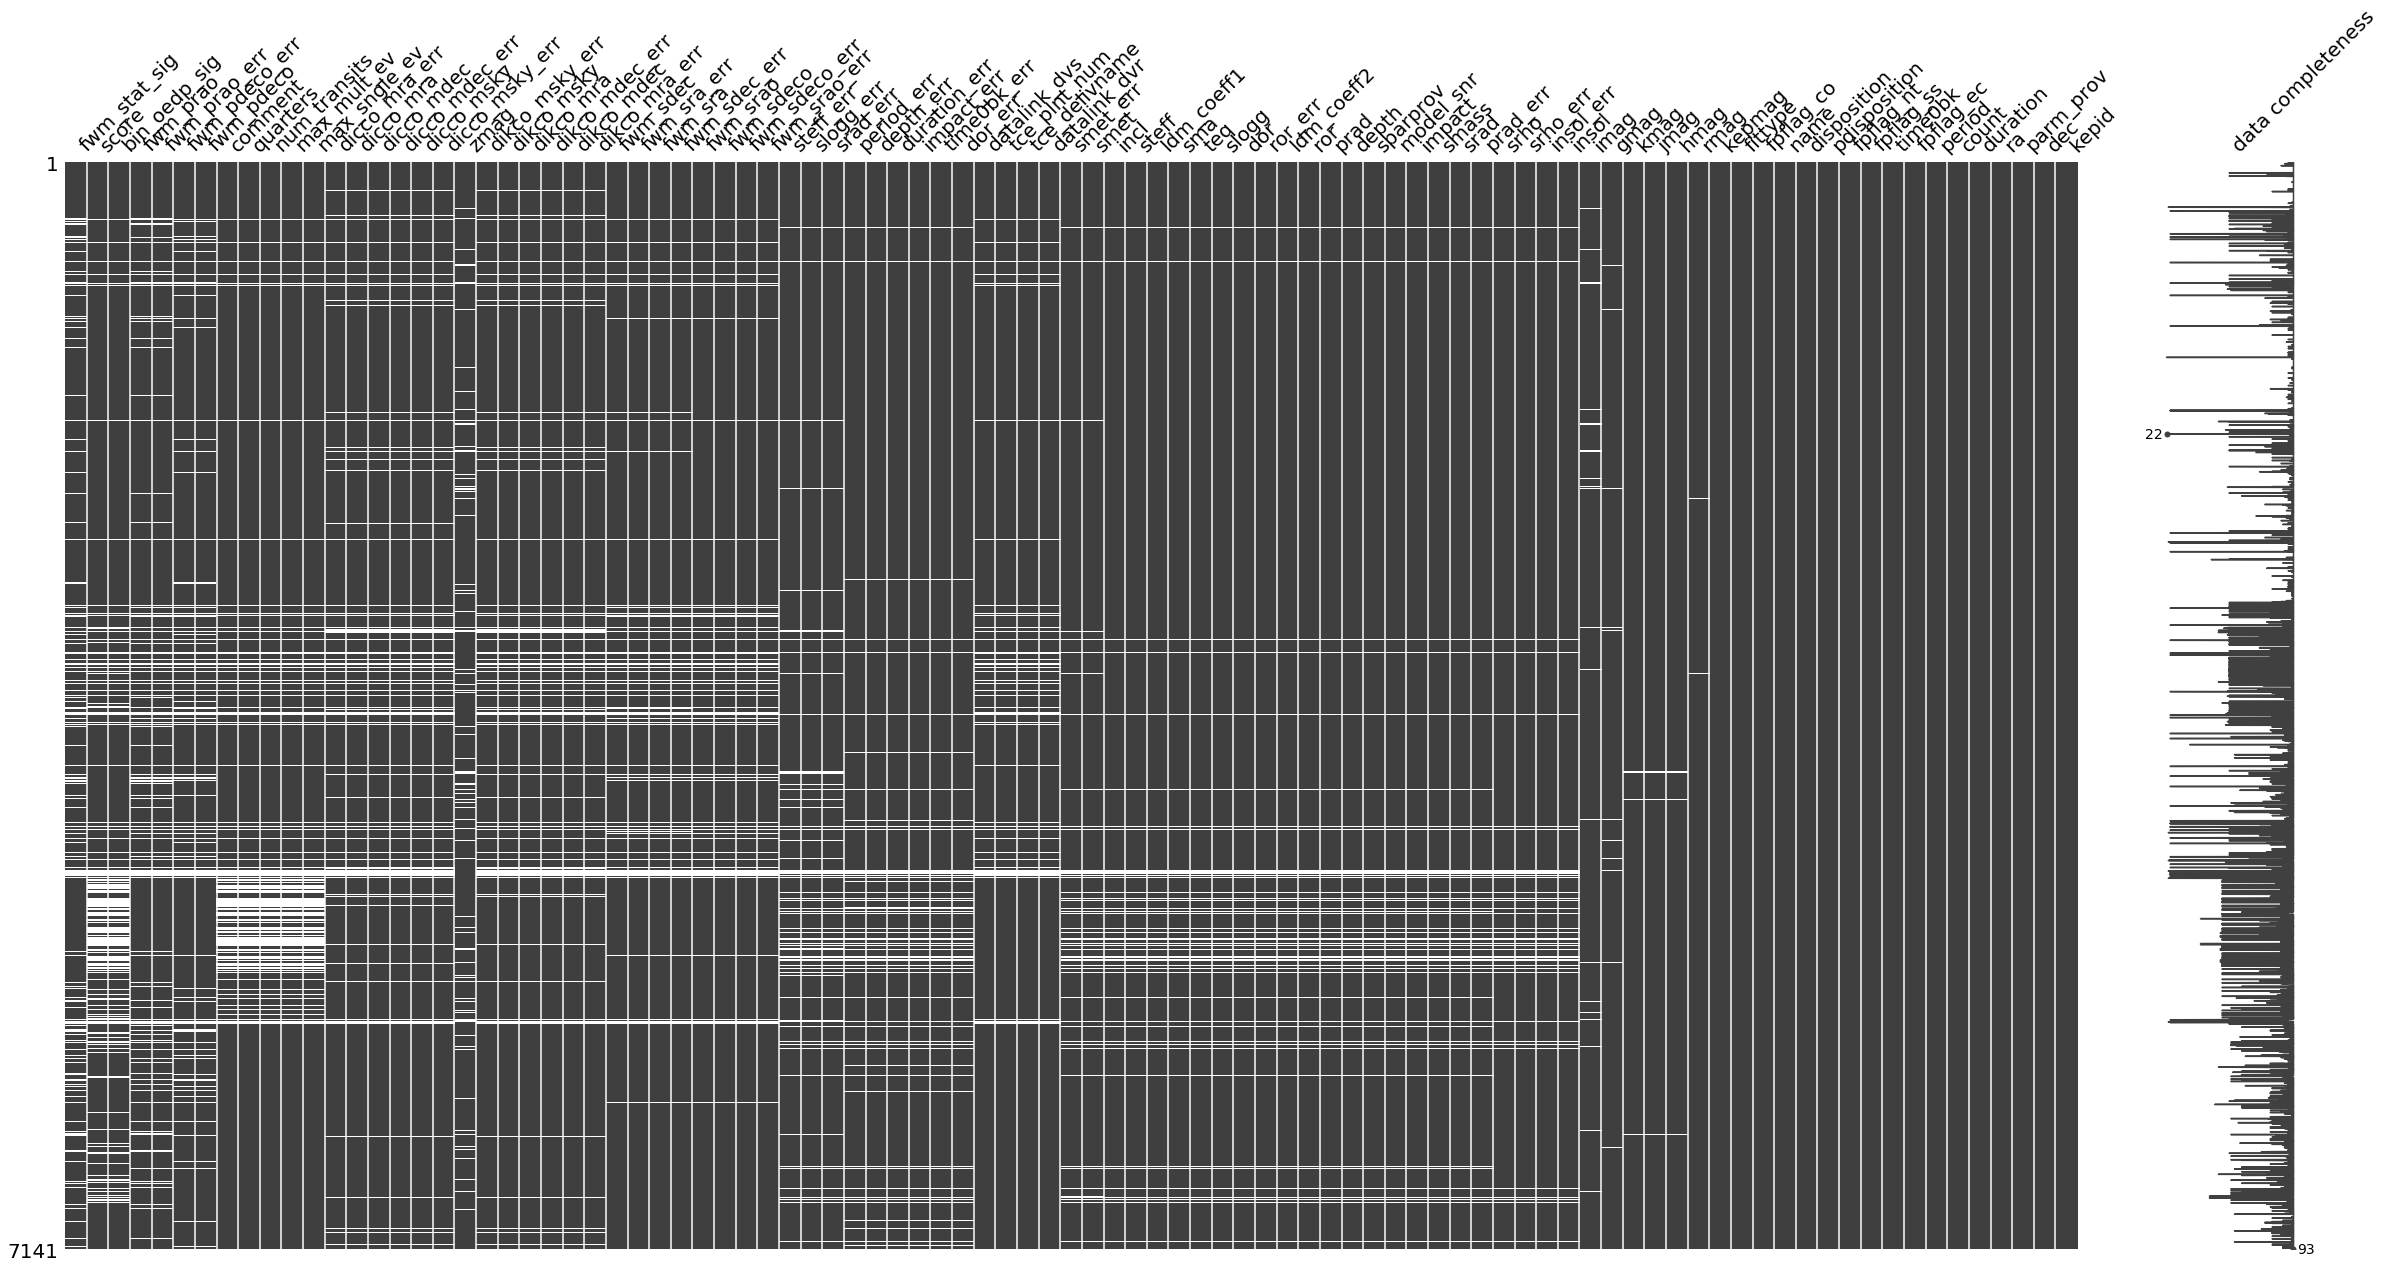

In [11]:
mn.matrix(df_koi[df_koi.isnull().sum().sort_values(ascending=False).index],
         labels = True, 
         figsize=(40,20), 
         fontsize=20)

Since the vast majority of the rows are mostly complete, we'll leave the data as is for now. Later we will impute the remaining missing values to compute feature importance and build the models.

Let's go ahead and split the data now so that 80% is used for training and validation, and 20% is used for testing. Then we'll begin exploring the training/validation data.

In [12]:
df_koi_train, df_koi_test = train_test_split(df_koi, test_size=0.2, random_state=4)

In [13]:
df_koi_train['disposition'].value_counts()

FALSE POSITIVE    3860
CONFIRMED         1852
Name: disposition, dtype: int64

In [14]:
df_koi_test['disposition'].value_counts()

FALSE POSITIVE    981
CONFIRMED         448
Name: disposition, dtype: int64

In [15]:
df_koi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7141 entries, 0 to 9563
Data columns (total 93 columns):
kepid             7141 non-null int64
name              7141 non-null object
disposition       7141 non-null object
pdisposition      7141 non-null object
score             6235 non-null float64
fpflag_nt         7141 non-null int64
fpflag_ss         7141 non-null int64
fpflag_co         7141 non-null int64
fpflag_ec         7141 non-null int64
comment           6459 non-null object
period            7141 non-null float64
period_err        6807 non-null float64
time0bk           7141 non-null float64
time0bk_err       6807 non-null float64
impact            6883 non-null float64
impact_err        6807 non-null float64
duration          7141 non-null float64
duration_err      6807 non-null float64
depth             6883 non-null float64
depth_err         6807 non-null float64
ror               6883 non-null float64
ror_err           6883 non-null float64
srho              6922 non-

### Exploratory data analysis

Now let's plot some columns to understand the data better. First let's take a look at the non-numeric features in our categories of interest.

In [16]:
# creating a list of columns with 'object' data type
obj_cols = [column for column in df_koi_train.columns[10:] if df_koi_train[column].dtype == np.object]
df_koi_train[obj_cols].head()

,fittype,parm_prov,tce_delivname,quarters,datalink_dvr,datalink_dvs,sparprov
6488,MCMC,q1_q16_koi,q1_q16_tce,NaN,006/006290/006290467/dv/kplr006290467-20130815...,006/006290/006290467/dv/kplr006290467-001-2013...,stellar_q1_q16
8135,none,q1_q17_dr24_koi,q1_q17_dr24_tce,11111111111111111000000000000000,009/009581/009581498/dv/kplr009581498-20141002...,009/009581/009581498/dv/kplr009581498-001-2014...,NaN
7956,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,11111111111111111000000000000000,008/008479/008479107/dv/kplr008479107-20160209...,008/008479/008479107/dv/kplr008479107-001-2016...,q1_q17_dr25_stellar
7704,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,11111111111111111000000000000000,009/009286/009286728/dv/kplr009286728-20160209...,009/009286/009286728/dv/kplr009286728-001-2016...,q1_q17_dr25_stellar
399,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,11111111111111111000000000000000,005/005866/005866099/dv/kplr005866099-20160209...,005/005866/005866099/dv/kplr005866099-001-2016...,q1_q17_dr25_stellar


In [17]:
print('Non-numeric categories and their corresponding number of unique entries:')
print()
for feature in obj_cols:
    print('{}: {}'.format(feature, uniques[feature]))

Non-numeric categories and their corresponding number of unique entries:

fittype: 4
parm_prov: 3
tce_delivname: 3
quarters: 212
datalink_dvr: 8063
datalink_dvs: 9218
sparprov: 4


Since the two features that end in 'prov' and the 'tce_delivname' feature only correspond to data release number and period that the features for their corresponding category were released, we'll ignore those. Furthermore, the two 'datalink...' features are just the web URLs where the data validation report and summary can be found, we'll ignore those as well. So let's first take a look at 'fittype' (the statistical fit method used to calculate the planetary parameters) for now and see how it's related to the disposition that we want to classify, then we can take a look at the 'quarters' feature.

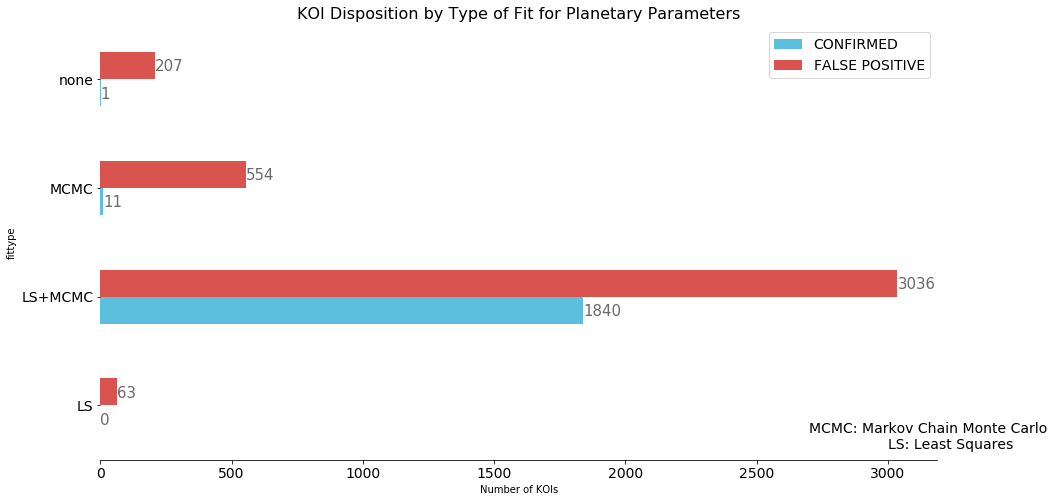

In [18]:
ax = df_koi_train.groupby(['disposition'])['fittype'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#5bc0de', '#d9534f'],
                                                                                   fontsize=14)
ax.annotate('MCMC: Markov Chain Monte Carlo', xy=(10, 0), xytext=(2700, -.25), size=14)
ax.annotate('LS: Least Squares', xy=(10, 0), xytext=(3000, -.4), size=14)
plt.legend(fontsize=14)
plt.title("KOI Disposition by Type of Fit for Planetary Parameters",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of KOIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Looks like KOIs where the fit type Least Squares was used are all classified as 'FALSE POSITIVE' , and less than 0.47% of KOIs not using any fit and 2.0% of KOIs with using the Markov Chain Monte Carlo fit are classified as 'CONFIRMED'. Let's binarize the 'fittype' feature to create a new column 'LS+MCMC' where it is 1 if LS+MCMC is used and 0 if not.

In [19]:
# binarizing 'fittype' column
df_koi_train = pd.concat([df_koi_train, pd.get_dummies(df_koi_train['fittype'])], axis=1)

# dropping irrelevant fittype columns
df_koi_train.drop(columns=['fittype', 'LS', 'MCMC', 'none'], inplace=True)

Now let's take a look at the 'quarters' feature. This feature is a bit string indicating which quarters of Kepler data were searched for transit signatures. Reading from left to right, the bits indicate the quarters, starting with quarter 1. A value of 1 for any bit means the designated quarter was searched for transits; a value of 0 means that quarter was not included in the transit search. First let's fill in the missing values with the mode, then let's count the number times the KOI was searched by counting the number of ones. Then we can see if there is any relationship between the number of quarters the data was searched for transit signatures and disposition.

In [20]:
# replace NaN values in 'quartes' with the most frequent value
df_koi_train['quarters'].fillna(df_koi_train['quarters'].mode()[0], inplace=True)

In [21]:
# count the number of quarters the KOI was searched
one_counts = []
for quarter in df_koi_train['quarters']:
    one_counts.append(quarter.count('1'))

# make counts a column to visualize
df_koi_train['nqs_searched'] = one_counts

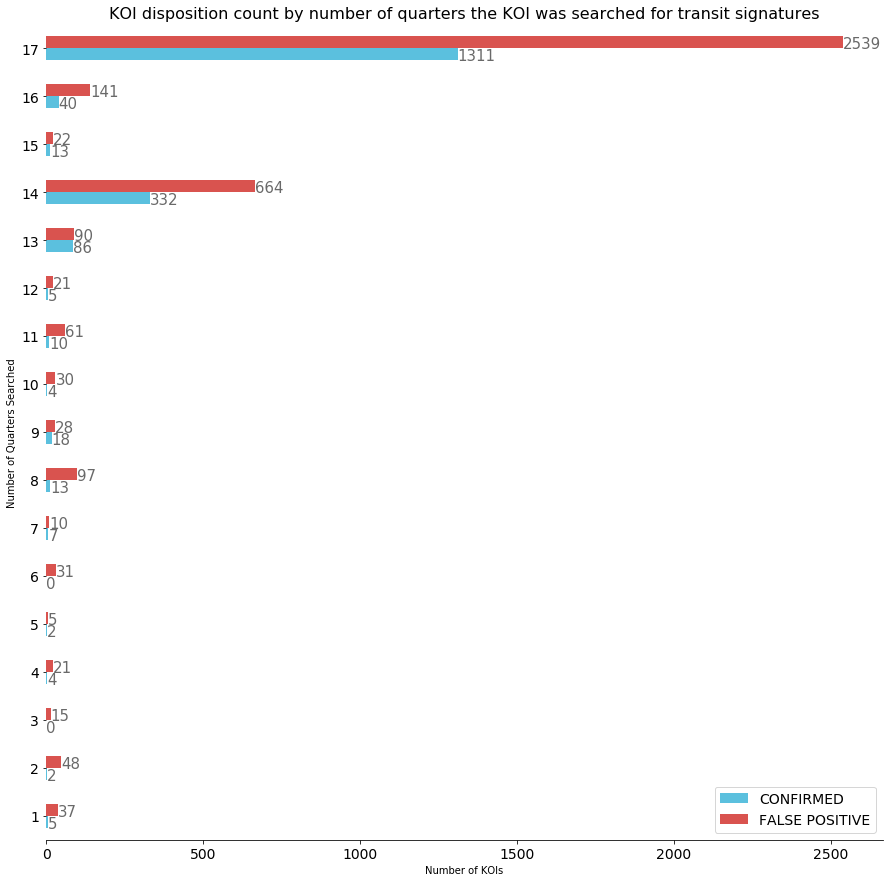

In [22]:
ax = df_koi_train.groupby(['disposition'])['nqs_searched'].value_counts().unstack(0).plot.barh(figsize=(15,15),
                                                                                   width=0.5,
                                                                                   color=['#5bc0de', '#d9534f'],
                                                                                   fontsize=14)


plt.legend(fontsize=14)
plt.title("KOI disposition count by number of quarters the KOI was searched for transit signatures",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y(), \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_ylabel('Number of Quarters Searched')
ax.set_xlabel('Number of KOIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Looks like this particular categorical feature won't be as helpful as the 'fittype' feature in classifying some of the KOIs, so let's go ahead and drop it from the list.

In [23]:
df_koi_train.drop(columns=['nqs_searched'], inplace=True)

Now let's take a look at some histograms of some of the numerical features to see how the features of the KOIs are distributed between the two classes 'CONFIRMED' and 'FALSE POSITIVE'.

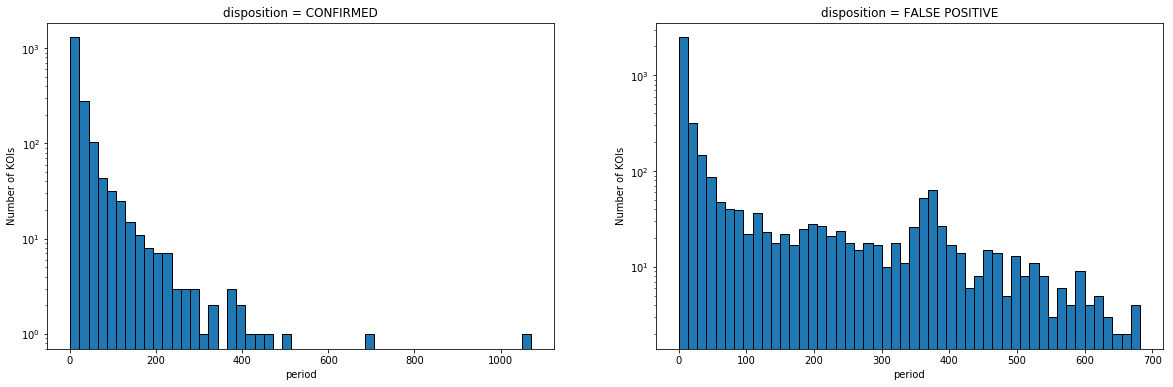

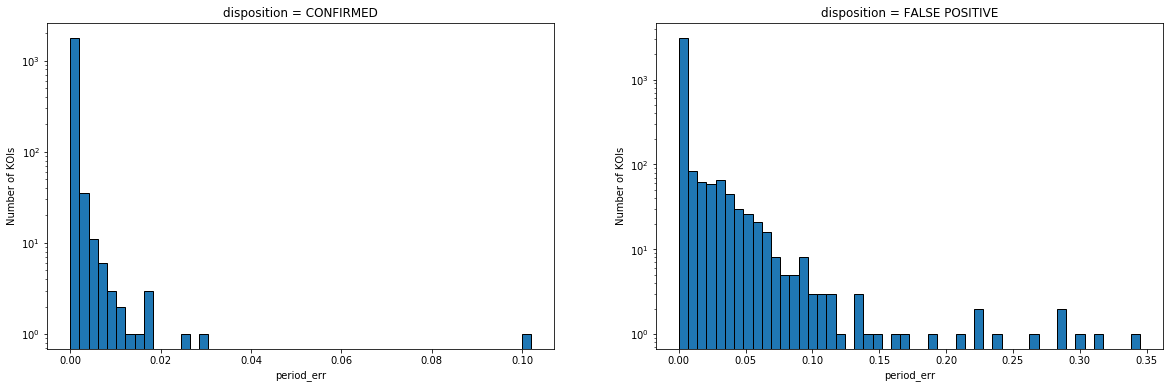

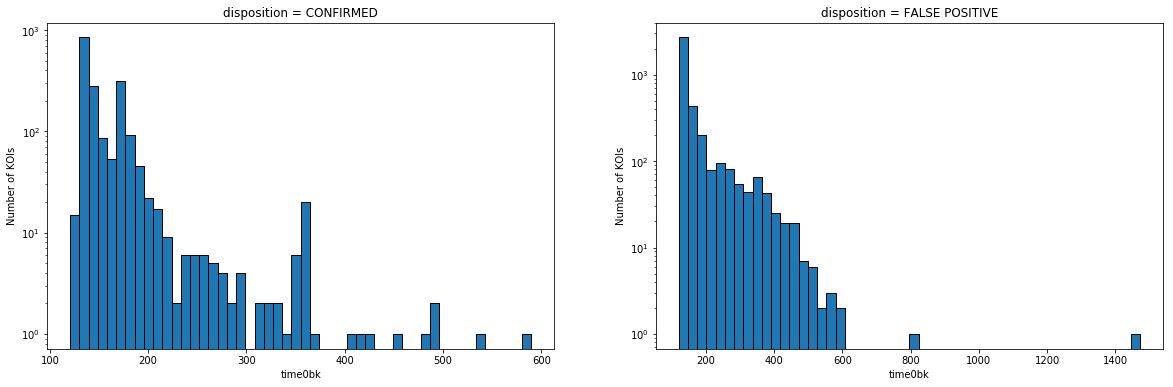

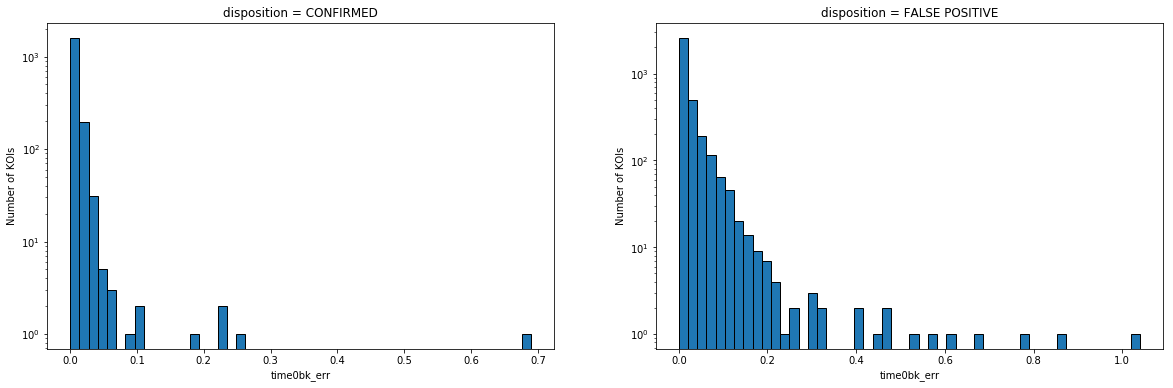

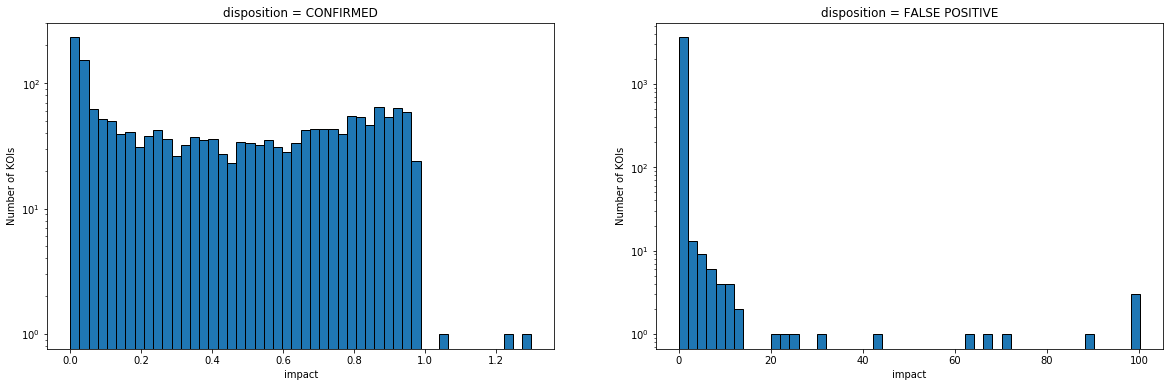

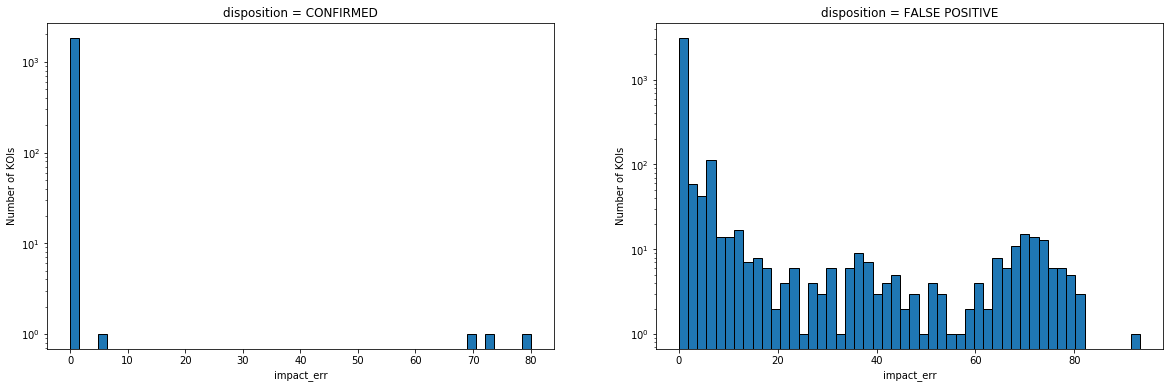

In [24]:
# creating a list of only the numerical columns in the categories of interest in df_koi_train
features = [column for column in df_koi_train.columns[10:] \
            if df_koi_train[column].dtype == np.float64 \
            or df_koi_train[column].dtype == np.int64 \
            or df_koi_train[column].dtype == np.uint8]

# plotting histograms of the first six numerical features in the transit properties category of features
for feature in features[0:6]:
    plot_hists(df_koi_train, feature)

Looks like some of the features do not have the same distribution or mean between the two classes. Let's do a two sample t-test to see which features have significantly different means between the two classes. This will allow us to identify features that may give us more info on whether or not a KOI is a CONFIRMED or FALSE POSITIVE exoplanet. Our null hypothesis for our t-test is that both "CONFIRMED" and "FALSE POSITIVE" KOIs have the same mean for any given numerical feature. Let's set our Alpha level to 0.05 and see which features we can reject the null hypothesis for.

In [25]:
pvalues = {}
for feature in features:
    conf = df_koi_train[df_koi_train['disposition'] == 'CONFIRMED'][feature]
    fp = df_koi_train[df_koi_train['disposition'] == 'FALSE POSITIVE'][feature]

    conf = conf.dropna()
    fp = fp.dropna()

    # apply 2-sample t-test to each feature assuming unequal standard deviations between the two classes
    pvalue = ws.ttest_ind(conf, fp, usevar='unequal')[1] 
    pvalues[feature] = pvalue
    
# create list of tuples (feature, pvalue) sorted by p-value 
features_pvalues = sorted(pvalues.items(), key=operator.itemgetter(1))

# create list of sorted pvalues
sorted_pvalues = [feature[1] for feature in features_pvalues]

# number of features with statistically significant different means b/w CONFIRMED and FALSE POSITIVE exoplanets
num_sig_features = len([pvalue for pvalue in sorted_pvalues if pvalue < 0.05])

print('Number of features with p-value less than alpha = 0.05: {}'.format(num_sig_features))
print('Total number of features: {}'.format(len(features)))

Number of features with p-value less than alpha = 0.05: 68
Total number of features: 77


Looks like there are 68 features out of 77 for which the p-value is less than 0.05, and for which we can reject the null hypothesis. Therefore, these 68 features have statistically different means between the two classes "CONFIRMED" and "FALSE POSITIVE". This is good news since the majority of the features have statistically different means between classifications it should make it easier for the algorithms to distinguish between the two classes.

Now let's take a look at feature importance using sklearn's ExtraTreesClassifier to see which features have the most information on classifying the KOIs as 'CONFIRMED' or 'FALSE POSITIVE', then we can compare those most important features of this list with the list of tuples that we made sorted by p-values.

Feature ranking:
1. count (0.083330)
2. smet_err (0.075679)
3. dicco_msky (0.050194)
4. dikco_msky (0.046431)
5. LS+MCMC (0.045419)
6. incl (0.031617)
7. steff_err (0.028333)
8. fwm_stat_sig (0.026842)
9. num_transits (0.025175)
10. ror (0.020715)
11. depth (0.019101)
12. max_sngle_ev (0.014917)
13. prad (0.014740)
14. impact_err (0.014575)
15. max_mult_ev (0.014369)
16. fwm_srao_err (0.014264)
17. bin_oedp_sig (0.014049)
18. fwm_sdec_err (0.013856)
19. smet (0.013757)
20. fwm_sdeco_err (0.013639)
21. ror_err (0.013638)
22. dikco_mra (0.013407)
23. dicco_mra (0.013282)
24. teq (0.013081)
25. prad_err (0.013000)
26. fwm_sra_err (0.012555)
27. sma (0.012525)
28. impact (0.012439)
29. duration_err (0.012191)
30. slogg_err (0.011726)
31. model_snr (0.011629)
32. tce_plnt_num (0.011179)
33. dicco_mdec (0.010785)
34. dikco_mdec (0.010281)
35. time0bk_err (0.009003)
36. dor (0.008496)
37. dikco_msky_err (0.008394)
38. depth_err (0.008102)
39. period (0.008049)
40. dikco_mdec_err (0.007983)
41

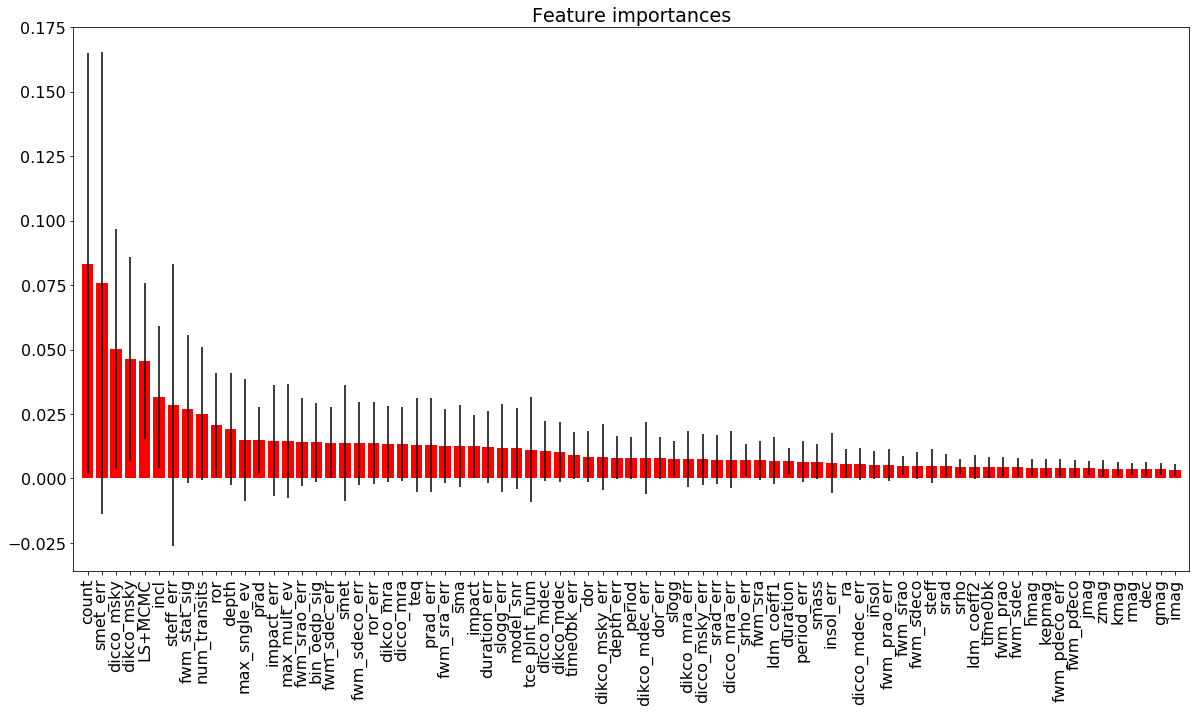

In [106]:
# imputing missing values with the mean using sklearn's SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# selecting all features to compute importance
X_train = df_koi_train[features]

# setting target variable
y_train = df_koi_train.loc[:,'disposition']


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(imp_mean.fit_transform(X_train), y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = [X_train.columns[index] for index in indices] #reordering features by importance
sorted_importances = [importances[index] for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Let's compare the top 10 features from the ExtraTreesClassifier to the top 10 features based off p-values to see if there are any similarities.

In [27]:
features[0:10]

['count',
 'smet_err',
 'dikco_msky',
 'dicco_msky',
 'LS+MCMC',
 'incl',
 'fwm_stat_sig',
 'num_transits',
 'steff_err',
 'ror']

In [28]:
[feature[0] for feature in features_pvalues[0:10]]

['smet_err',
 'dicco_msky',
 'steff_err',
 'dikco_msky',
 'incl',
 'count',
 'LS+MCMC',
 'smet',
 'num_transits',
 'teq']

Interesting, 8 of the 77 total features appear in both lists of top 10 features. Let's calculate the correlation coefficient between the two and see how strong it is.

In [29]:
corr = np.corrcoef(sorted_importances[0:10], sorted_pvalues[0:10])[0][1]
print('Correlation coefficient between top 10 p-values list and top 10 ETC list: {:.2f}'.format(corr))

Correlation coefficient between top 10 p-values list and top 10 ETC list: -0.35


Although the correlation isn't very strong there does seem to be some correlation between the top 10 p-values and the top 10 important features as calculated by the ExtraTreesClassifier.

Let's go ahead and tune and cross validate the algorithms using RandomizedSearchCV on the metric MAP score to see how they perform using all features, then we can remove less important features to see if it improves the metric and/or runtime of each algorithm. 

First let's assign variables to select approximately 25%, 50%, 75%, and 100% of the features we're going to use and repeat the preprocessing on the test data in order to evaluate the classification algorithms.

In [30]:
# selecting 100%, 75%, 50%, and 25% of features to compute importance
X_train100 = df_koi_train[features]
X_train75 = df_koi_train[features[:round(len(features)*.75)]]
X_train50 = df_koi_train[features[:round(len(features)*.5)]]
X_train25 = df_koi_train[features[:round(len(features)*.25)]]

# setting target variable
y_train = (df_koi_train.disposition == 'CONFIRMED').values.astype(np.int)

# repeating pre-processing for the test data

# one-hot encoding of 'fittype' feature
df_koi_test = pd.concat([df_koi_test, pd.get_dummies(df_koi_test['fittype'])], axis=1)

# dropping irrelevant fittype columns
df_koi_test.drop(columns=['fittype', 'LS', 'MCMC', 'none'], inplace=True)

X_test = df_koi_test[features]
y_test = (df_koi_test.disposition == 'CONFIRMED').values.astype(np.int)

In [31]:
print(X_train.info())
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712 entries, 6488 to 1350
Data columns (total 77 columns):
period            5712 non-null float64
period_err        5446 non-null float64
time0bk           5712 non-null float64
time0bk_err       5446 non-null float64
impact            5508 non-null float64
impact_err        5446 non-null float64
duration          5712 non-null float64
duration_err      5446 non-null float64
depth             5508 non-null float64
depth_err         5446 non-null float64
ror               5508 non-null float64
ror_err           5508 non-null float64
srho              5541 non-null float64
srho_err          5541 non-null float64
prad              5508 non-null float64
prad_err          5508 non-null float64
sma               5508 non-null float64
incl              5507 non-null float64
teq               5508 non-null float64
insol             5541 non-null float64
insol_err         5541 non-null float64
dor               5508 non-null float64
dor_err   

,period,period_err,time0bk,time0bk_err,impact,impact_err,duration,duration_err,depth,depth_err,ror,ror_err,srho,srho_err,prad,prad_err,sma,incl,teq,insol,insol_err,dor,dor_err,ldm_coeff2,ldm_coeff1,max_sngle_ev,max_mult_ev,model_snr,count,num_transits,tce_plnt_num,bin_oedp_sig,steff,steff_err,slogg,slogg_err,smet,smet_err,srad,srad_err,smass,ra,dec,kepmag,gmag,rmag,imag,zmag,jmag,hmag,kmag,fwm_stat_sig,fwm_sra,fwm_sra_err,fwm_sdec,fwm_sdec_err,fwm_srao,fwm_srao_err,fwm_sdeco,fwm_sdeco_err,fwm_prao,fwm_prao_err,fwm_pdeco,fwm_pdeco_err,dicco_mra,dicco_mra_err,dicco_mdec,dicco_mdec_err,dicco_msky,dicco_msky_err,dikco_mra,dikco_mra_err,dikco_mdec,dikco_mdec_err,dikco_msky,dikco_msky_err,LS+MCMC
6488,100.629443,3.730000e-03,189.624700,0.023200,0.0726,0.4936,1.70800,0.78400,355.7,179.8,0.017431,0.004967,178.06807,346.89136,1.75,0.71,0.4248,89.95,412.0,6.84,8.27,457.0000,440.0000,0.3047,0.2962,NaN,NaN,4.7,1,NaN,1.0,NaN,6351.0,371.0,4.513,0.290,-0.50,0.56,0.921,0.377,1.008,293.54422,41.652641,15.080,15.442,15.044,14.924,14.890,14.070,13.775,13.682,0.666,19.569576,3.000000e-05,41.652600,2.700000e-04,-1.60000,1.2000,-0.14000,0.96000,0.000000,0.000470,-0.000170,0.000380,4.400,1.600,2.510,0.430,5.100,1.400,1.060,0.980,0.940,0.780,1.420,0.890,0
8135,10.548848,NaN,140.387434,NaN,NaN,NaN,1.17000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.092143,7.484054,NaN,1,125.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.92041,46.221142,14.184,14.664,14.152,13.978,13.881,13.026,12.688,12.594,0.000,19.261460,4.300000e-05,46.221080,4.200000e-04,3.70000,1.6000,-0.20000,1.50000,-0.000430,0.000190,0.000020,0.000180,-0.500,1.000,1.500,1.300,1.600,1.100,-0.500,1.200,1.500,1.200,1.600,1.100,0
7956,0.767577,2.300000e-07,131.819082,0.000242,0.8210,0.1040,2.04757,0.01156,157610.0,482.0,0.500009,0.071495,1.70736,0.10209,34.23,5.46,0.0140,77.39,1530.0,1294.42,718.79,3.7604,0.1064,0.2787,0.3888,200.209520,1527.705700,431.3,1,1743.0,1.0,0.8836,5182.0,298.0,4.635,0.105,-0.98,0.60,0.627,0.100,0.619,284.12561,44.550571,14.952,15.586,14.924,14.681,14.541,13.571,13.052,12.965,NaN,18.941712,2.100000e-08,44.550497,2.300000e-07,0.14363,0.0008,-0.26324,0.00082,0.020000,0.092000,NaN,NaN,-0.004,0.067,0.006,0.067,0.008,0.067,0.088,0.068,-0.136,0.068,0.162,0.068,1
7704,3.044597,9.182000e-05,132.498900,0.030600,0.3850,0.4780,7.63800,0.67600,66.1,8.4,0.007496,0.000669,0.05043,0.03051,0.62,0.16,0.0386,82.41,1076.0,317.36,259.13,2.9130,1.8480,0.2521,0.4210,5.649042,9.527407,18.2,1,447.0,1.0,0.7658,5525.0,313.0,4.603,0.157,-0.36,0.60,0.753,0.201,0.843,294.15503,45.707230,14.567,15.107,14.507,14.335,14.207,13.295,12.912,12.828,0.113,19.610313,3.500000e-05,45.706850,3.900000e-04,-0.90000,1.3000,-1.40000,1.40000,0.000037,0.000053,0.000057,0.000057,0.470,0.580,-0.370,0.400,0.590,0.410,0.490,0.600,-0.190,0.450,0.530,0.510,1
399,36.977088,1.701000e-04,133.626810,0.003900,1.2460,70.7020,4.73700,0.20200,1269.9,51.0,0.285292,70.607430,0.09440,42.16928,38.60,23.12,0.2077,86.23,602.0,31.08,45.45,18.9700,19.0000,0.2427,0.4368,26.544245,70.083470,59.2,1,38.0,1.0,0.0381,5589.0,321.0,4.193,0.500,-0.10,0.55,1.239,0.742,0.873,288.44287,41.172180,13.698,14.259,13.635,13.457,13.357,12.393,11.985,11.959,0.000,19.230442,2.900000e-06,41.173996,3.300000e-05,37.27000,0.1200,6.54000,0.12000,-0.046760,0.000300,-0.007880,0.000380,7.024,0.068,1.564,0.071,7.196,0.069,7.233,0.069,1.517,0.071,7.391,0.070,1


## Classification and Cross Validation

Now let's fit and cross validate the models with the following classification algorithms for each set of features:

- Logistic Regression
- Support Vector Machine
- Random Forest
- XGBoost

For each algorithm, we will first define a parameter space for the hyper-parameters, then we will search through the parameter space using RandomizedSearchCV to select the hyper-parameters that give us the highest average 5-fold cross validation score on the training data. Lastly, we will select the best performing model and apply it to the test data to see how it performs on unseen data.

### Logistic Regression

In [32]:
# create LogisticRegression model and pipeline
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=7)
lr_steps = [('imputation', imp_mean), ('scaler', StandardScaler()), ('LR', logreg)]
lr_pipeline = Pipeline(lr_steps)

# paramater space to tune
c_space = np.logspace(-5,8,15)
lr_param_grid = {'LR__C': c_space}

In [33]:
%%time
# apply 5 fold cross validation with RandomizedSearchCV to find best hyper-paramters and fit model
logreg_cv25 = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='average_precision', cv=5, random_state=10)
logreg_cv25.fit(X_train25, y_train)

# print results
print("5 fold cross validation results using top 25% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(logreg_cv25.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv25.cv_results_['std_test_score'])))

5 fold cross validation results using top 25% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.966
Standard deviation: 0.007
CPU times: user 24.3 s, sys: 0 ns, total: 24.3 s
Wall time: 12.2 s


In [34]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV to each set of features
logreg_cv50 = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='average_precision', cv=5, random_state=10)
logreg_cv50.fit(X_train50, y_train)

# print results
print("5 fold cross validation results using top 50% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(logreg_cv50.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv50.cv_results_['std_test_score'])))

5 fold cross validation results using top 50% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.979
Standard deviation: 0.005
CPU times: user 1min 23s, sys: 7.48 ms, total: 1min 23s
Wall time: 41.7 s


In [35]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV to each set of features
logreg_cv75 = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='average_precision', cv=5, random_state=10)
logreg_cv75.fit(X_train75, y_train)

# print results
print("5 fold cross validation results using top 75% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(logreg_cv75.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv75.cv_results_['std_test_score'])))

5 fold cross validation results using top 75% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.979
Standard deviation: 0.008
CPU times: user 1min 27s, sys: 11.9 ms, total: 1min 27s
Wall time: 43.7 s


In [36]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV to each set of features
logreg_cv100 = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='average_precision', cv=5, random_state=10)
logreg_cv100.fit(X_train100, y_train)

# print results
print("5 fold cross validation results using all features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(logreg_cv100.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv100.cv_results_['std_test_score'])))

5 fold cross validation results using all features
---------------------------------------------------------------------
Mean CV MAP: 0.976
Standard deviation: 0.010
CPU times: user 2min 7s, sys: 39.9 ms, total: 2min 8s
Wall time: 1min 4s


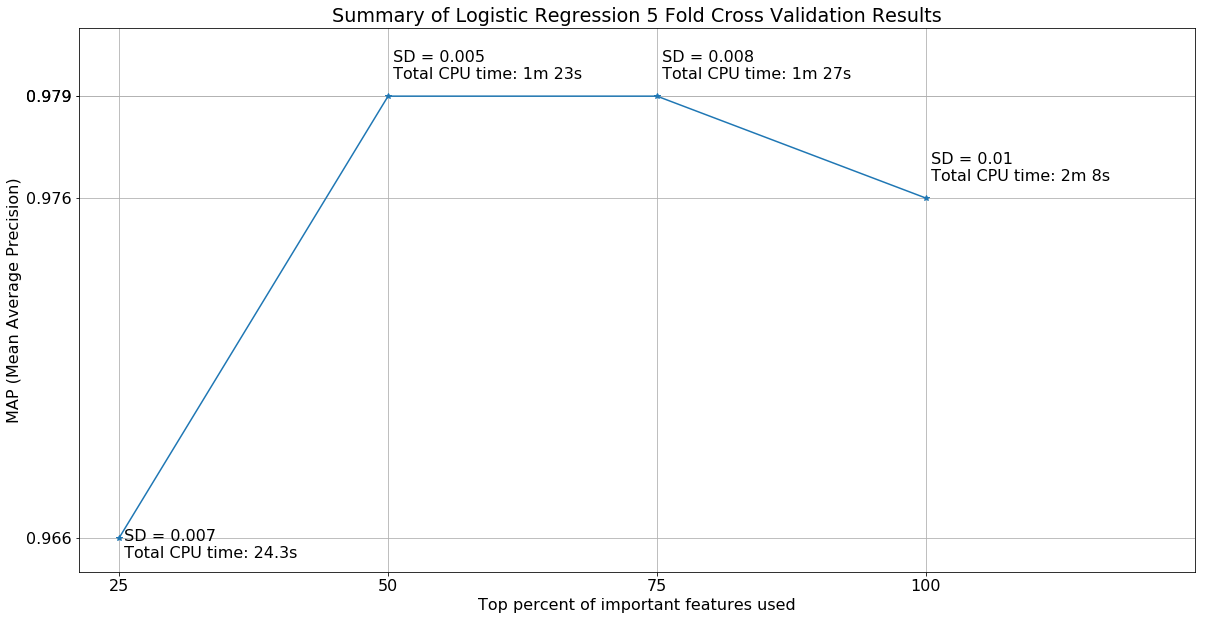

In [105]:
mpl.rcParams["font.size"] = 16
lr25 = round(np.mean(logreg_cv25.cv_results_['mean_test_score']), 3)
lr50 = round(np.mean(logreg_cv50.cv_results_['mean_test_score']), 3)
lr75 = round(np.mean(logreg_cv75.cv_results_['mean_test_score']), 3)
lr100 = round(np.mean(logreg_cv100.cv_results_['mean_test_score']), 3)
plt.figure(figsize=(20, 10))
plt.plot([25, 50, 75, 100], [lr25, lr50, lr75, lr100], marker='*')
plt.xticks([25, 50, 75, 100])
plt.yticks([lr25, lr50, lr75, lr100])
plt.title('Summary of Logistic Regression 5 Fold Cross Validation Results')
plt.xlabel('Top percent of important features used')
plt.ylabel('MAP (Mean Average Precision)')
plt.ylim(lr25 - .001, lr50 + .002)
plt.xlim(right=125)
plt.grid(b=True)

# Annotate Text
plt.annotate(' SD = 0.007 \n Total CPU time: 24.3s', xy=(25, lr25 - .0006))
plt.annotate(' SD = 0.005 \n Total CPU time: 1m 23s', xy=(50, lr50 + .0005))
plt.annotate(' SD = 0.008 \n Total CPU time: 1m 27s', xy=(75, lr75 + .0005))
plt.annotate(' SD = 0.01 \n Total CPU time: 2m 8s', xy=(100, lr100 + .0005))
plt.show()

### SVM (Support Vector Machine)

In [44]:
# create SVM model and pipeline
svm = SVC(random_state=7)
svm_steps = [('imputation', imp_mean), ('scaler', StandardScaler()), ('SVM', svm)]
svm_pipeline = Pipeline(svm_steps)

# paramater space to tune
c_space = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
gamma_space = [1e-2, 1e-3, 1e-4, 1e-5]
kernels = ['rbf', 'linear', 'sigmoid']
svm_param_grid = {'SVM__C': c_space, 'SVM__gamma': gamma_space, 'SVM__kernel': kernels}

In [45]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
svm_cv25 = RandomizedSearchCV(svm_pipeline, svm_param_grid, scoring='average_precision', cv=5, random_state=10)
svm_cv25.fit(X_train25, y_train)

# print results
print("5 fold cross validation results using top 25% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(svm_cv25.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(svm_cv25.cv_results_['std_test_score'])))

5 fold cross validation results using top 25% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.946
Standard deviation: 0.007
CPU times: user 54.3 s, sys: 8.01 ms, total: 54.3 s
Wall time: 54.3 s


In [46]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
svm_cv50 = RandomizedSearchCV(svm_pipeline, svm_param_grid, scoring='average_precision', cv=5, random_state=10)
svm_cv50.fit(X_train50, y_train)

# print results
print("5 fold cross validation results using top 50% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(svm_cv50.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(svm_cv50.cv_results_['std_test_score'])))

5 fold cross validation results using top 50% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.967
Standard deviation: 0.006
CPU times: user 1min 10s, sys: 3.98 ms, total: 1min 10s
Wall time: 1min 10s


In [47]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
svm_cv75 = RandomizedSearchCV(svm_pipeline, svm_param_grid, scoring='average_precision', cv=5, random_state=10)
svm_cv75.fit(X_train75, y_train)

# print results
print("5 fold cross validation results using top 75% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(svm_cv75.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(svm_cv75.cv_results_['std_test_score'])))

5 fold cross validation results using top 75% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.969
Standard deviation: 0.008
CPU times: user 2min 30s, sys: 80 ms, total: 2min 30s
Wall time: 2min 11s


In [48]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
svm_cv100 = RandomizedSearchCV(svm_pipeline, svm_param_grid, scoring='average_precision', cv=5, random_state=10)
svm_cv100.fit(X_train100, y_train)

print("5 fold cross validation results using all features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(svm_cv100.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(svm_cv100.cv_results_['std_test_score'])))

5 fold cross validation results using all features
---------------------------------------------------------------------
Mean CV MAP: 0.969
Standard deviation: 0.007
CPU times: user 3min 9s, sys: 47.9 ms, total: 3min 9s
Wall time: 2min 48s


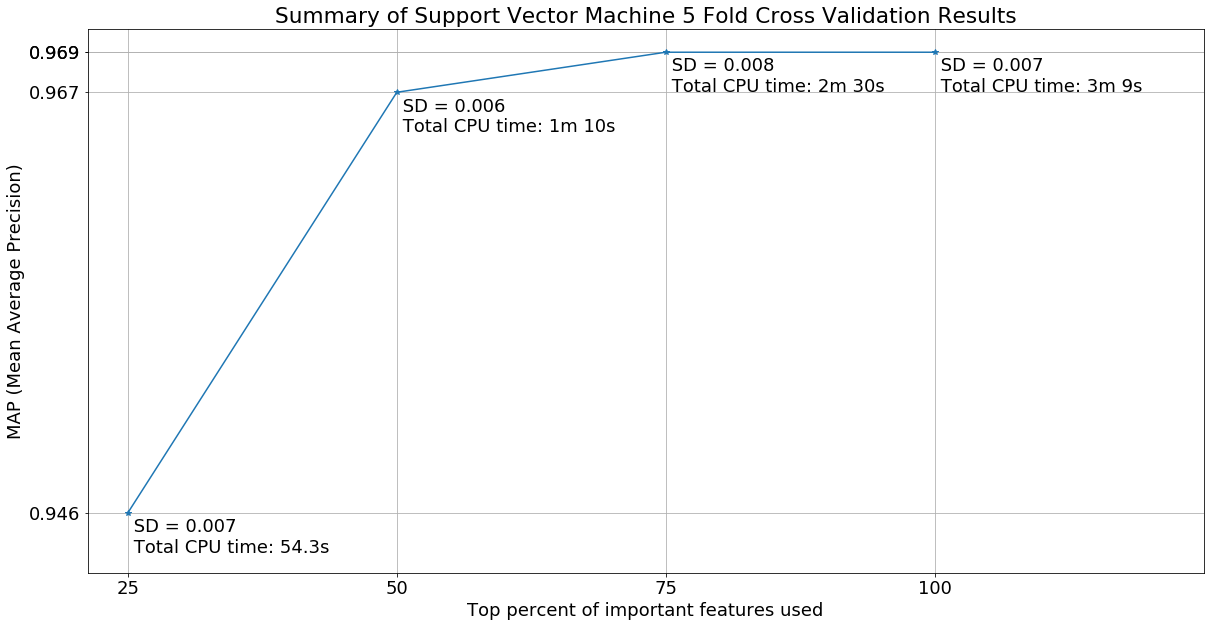

In [75]:
svm25 = round(np.mean(svm_cv25.cv_results_['mean_test_score']), 3)
svm50 = round(np.mean(svm_cv50.cv_results_['mean_test_score']), 3)
svm75 = round(np.mean(svm_cv75.cv_results_['mean_test_score']), 3)
svm100 = round(np.mean(svm_cv100.cv_results_['mean_test_score']), 3)
plt.figure(figsize=(20, 10))
plt.plot([25, 50, 75, 100], [svm25, svm50, svm75, svm100], marker='*')
plt.xticks([25, 50, 75, 100])
plt.yticks([svm25, svm50, svm75, svm100])
plt.title('Summary of Support Vector Machine 5 Fold Cross Validation Results')
plt.xlabel('Top percent of important features used')
plt.ylabel('MAP (Mean Average Precision)')
plt.ylim(bottom=svm25 - .003)
plt.xlim(right=125)
plt.grid(b=True)
# Annotate Text
plt.annotate(' SD = 0.007 \n Total CPU time: 54.3s', xy=(25, svm25 - .002))
plt.annotate(' SD = 0.006 \n Total CPU time: 1m 10s', xy=(50, svm50 - .002))
plt.annotate(' SD = 0.008 \n Total CPU time: 2m 30s', xy=(75, svm75 - .002))
plt.annotate(' SD = 0.007 \n Total CPU time: 3m 9s', xy=(100, svm100 - .002))
plt.show()

### Random Forest

In [53]:
rfc = RandomForestClassifier(random_state=7)
rfc_steps = [('imputation', imp_mean), ('scaler', StandardScaler()), ('RFC', rfc)]
rfc_pipeline = Pipeline(rfc_steps)

# paramater space to tune
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rfc_param_grid = {'RFC__n_estimators': n_estimators,
                  'RFC__max_features': max_features,
                  'RFC__max_depth': max_depth,
                  'RFC__min_samples_split': min_samples_split,
                  'RFC__min_samples_leaf': min_samples_leaf,
                  'RFC__bootstrap': bootstrap}

In [54]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
rfc_cv25 = RandomizedSearchCV(rfc_pipeline, rfc_param_grid, scoring='average_precision', cv=5, random_state=10)
rfc_cv25.fit(X_train25, y_train)

# print results
print("5 fold cross validation results using top 25% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(rfc_cv25.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(rfc_cv25.cv_results_['std_test_score'])))

5 fold cross validation results using top 25% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.988
Standard deviation: 0.004
CPU times: user 8min 28s, sys: 60 ms, total: 8min 28s
Wall time: 8min 28s


In [55]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
rfc_cv50 = RandomizedSearchCV(rfc_pipeline, rfc_param_grid, scoring='average_precision', cv=5, random_state=10)
rfc_cv50.fit(X_train50, y_train)

# print results
print("5 fold cross validation results using top 50% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(rfc_cv50.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(rfc_cv50.cv_results_['std_test_score'])))

5 fold cross validation results using top 50% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.992
Standard deviation: 0.004
CPU times: user 14min 1s, sys: 128 ms, total: 14min 1s
Wall time: 14min 1s


In [56]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
rfc_cv75 = RandomizedSearchCV(rfc_pipeline, rfc_param_grid, scoring='average_precision', cv=5, random_state=10)
rfc_cv75.fit(X_train75, y_train)

# print results
print("5 fold cross validation results using top 75% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(rfc_cv75.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(rfc_cv75.cv_results_['std_test_score'])))

5 fold cross validation results using top 75% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.994
Standard deviation: 0.003
CPU times: user 17min 1s, sys: 176 ms, total: 17min 1s
Wall time: 16min 41s


In [57]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
rfc_cv100 = RandomizedSearchCV(rfc_pipeline, rfc_param_grid, scoring='average_precision', cv=5, random_state=10)
rfc_cv100.fit(X_train100, y_train)

print("5 fold cross validation results using all features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(rfc_cv100.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(rfc_cv100.cv_results_['std_test_score'])))

5 fold cross validation results using all features
---------------------------------------------------------------------
Mean CV MAP: 0.994
Standard deviation: 0.003
CPU times: user 20min 46s, sys: 316 ms, total: 20min 46s
Wall time: 20min 27s


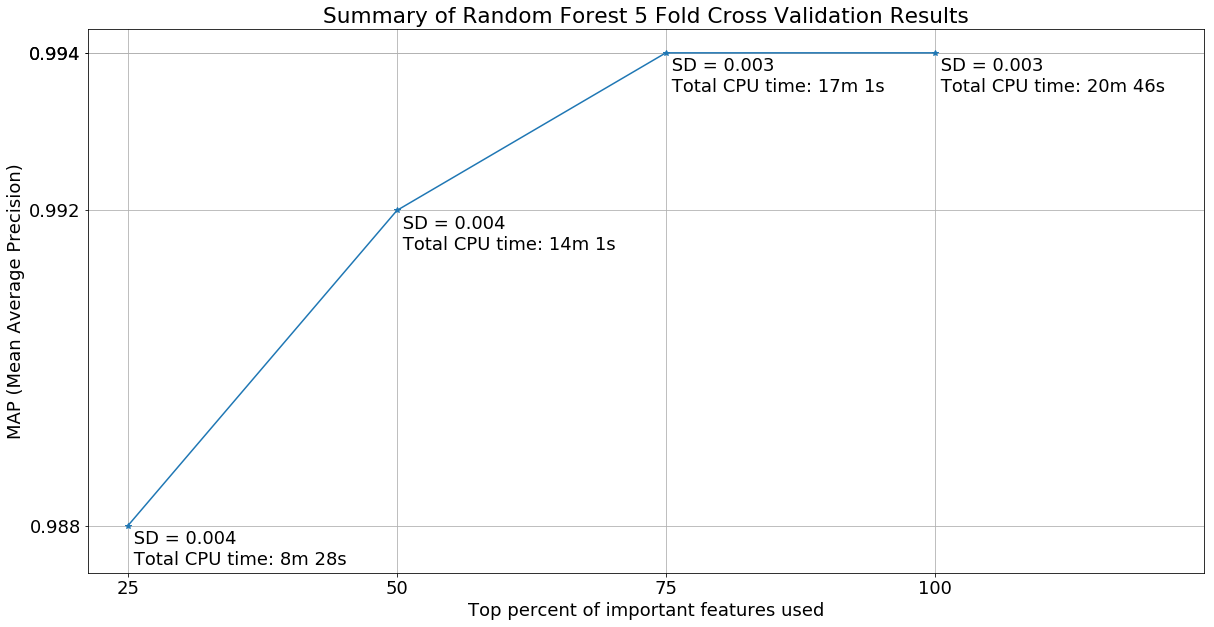

In [72]:
rf25 = round(np.mean(rfc_cv25.cv_results_['mean_test_score']), 3)
rf50 = round(np.mean(rfc_cv50.cv_results_['mean_test_score']), 3)
rf75 = round(np.mean(rfc_cv75.cv_results_['mean_test_score']), 3)
rf100 = round(np.mean(rfc_cv100.cv_results_['mean_test_score']), 3)
plt.figure(figsize=(20, 10))
plt.plot([25, 50, 75, 100], [rf25, rf50, rf75, rf100], marker='*')
plt.xticks([25, 50, 75, 100])
plt.yticks([rf25, rf50, rf75, rf100])
plt.title('Summary of Random Forest 5 Fold Cross Validation Results')
plt.xlabel('Top percent of important features used')
plt.ylabel('MAP (Mean Average Precision)')
plt.ylim(rf25 - .0006)
plt.xlim(right=125)
plt.grid(b=True)
# Annotate Text

plt.annotate(' SD = 0.004 \n Total CPU time: 8m 28s', xy=(25, rf25 - .0005))
plt.annotate(' SD = 0.004 \n Total CPU time: 14m 1s', xy=(50, rf50 - .0005))
plt.annotate(' SD = 0.003 \n Total CPU time: 17m 1s', xy=(75, rf75 - .0005))
plt.annotate(' SD = 0.003 \n Total CPU time: 20m 46s', xy=(100, rf100 - .0005))
plt.show()

### XGBoost

In [62]:
xgb = XGBClassifier(subsample=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=7)
xgb_steps = [('imputation', imp_mean), ('scaler', StandardScaler()), ('XGB', xgb)]
xgb_pipeline = Pipeline(xgb_steps)

# paramater space to tune
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
min_child_weight = [1, 3, 5, 7]
gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
colsample_bytree = [0.3, 0.4, 0.5 , 0.7]

xgb_param_grid = {'XGB__max_depth': max_depth, 
                  'XGB__learning_rate': learning_rate, 
                  'XGB__n_estimators': n_estimators, 
                  'XGB__gamma': gamma, 
                  'XGB__min_child_weight': min_child_weight, 
                  'XGB__colsample_bytree': colsample_bytree,
}

In [63]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv25 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='average_precision', cv=5, random_state=10)
xgb_cv25.fit(X_train25, y_train)

# print results
print("5 fold cross validation results using top 25% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(xgb_cv25.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv25.cv_results_['std_test_score'])))

5 fold cross validation results using top 25% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.988
Standard deviation: 0.004
CPU times: user 6min 59s, sys: 618 ms, total: 7min
Wall time: 1min 52s


In [64]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv50 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='average_precision', cv=5, random_state=10)
xgb_cv50.fit(X_train50, y_train)

# print results
print("5 fold cross validation results using top 50% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(xgb_cv50.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv50.cv_results_['std_test_score'])))

5 fold cross validation results using top 50% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.991
Standard deviation: 0.007
CPU times: user 10min 12s, sys: 804 ms, total: 10min 13s
Wall time: 2min 42s


In [65]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv75 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='average_precision', cv=5, random_state=10)
xgb_cv75.fit(X_train75, y_train)

# print results
print("5 fold cross validation results using top 75% most important features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(xgb_cv75.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv75.cv_results_['std_test_score'])))

5 fold cross validation results using top 75% most important features
---------------------------------------------------------------------
Mean CV MAP: 0.994
Standard deviation: 0.003
CPU times: user 15min 3s, sys: 1.84 s, total: 15min 5s
Wall time: 4min 10s


In [66]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv100 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='average_precision', cv=5, random_state=10)
xgb_cv100.fit(X_train100, y_train)

print("5 fold cross validation results using all features")
print("---------------------------------------------------------------------")
print("Mean CV MAP: {:.3f}".format(np.mean(xgb_cv100.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv100.cv_results_['std_test_score'])))

5 fold cross validation results using all features
---------------------------------------------------------------------
Mean CV MAP: 0.995
Standard deviation: 0.002
CPU times: user 19min 10s, sys: 2.12 s, total: 19min 12s
Wall time: 5min 21s


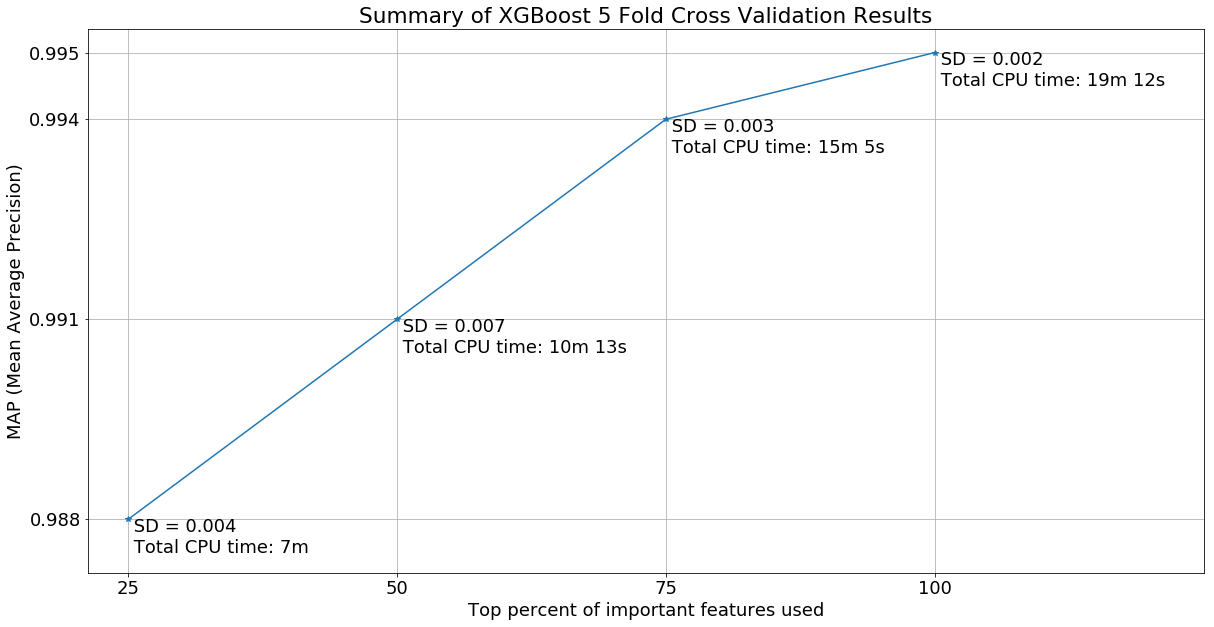

In [71]:
xgb25 = round(np.mean(xgb_cv25.cv_results_['mean_test_score']), 3)
xgb50 = round(np.mean(xgb_cv50.cv_results_['mean_test_score']), 3)
xgb75 = round(np.mean(xgb_cv75.cv_results_['mean_test_score']), 3)
xgb100 = round(np.mean(xgb_cv100.cv_results_['mean_test_score']), 3)
plt.figure(figsize=(20, 10))
plt.plot([25, 50, 75, 100], [xgb25, xgb50, xgb75, xgb100], marker='*')
plt.xticks([25, 50, 75, 100])
plt.yticks([xgb25, xgb50, xgb75, xgb100])
plt.title('Summary of XGBoost 5 Fold Cross Validation Results')
plt.xlabel('Top percent of important features used')
plt.ylabel('MAP (Mean Average Precision)')
plt.ylim(xgb25 - .0008)
plt.xlim(right=125)
plt.grid(b=True)

# Annotate Text
plt.annotate(' SD = 0.004 \n Total CPU time: 7m', xy=(25, xgb25 - .0005))
plt.annotate(' SD = 0.007 \n Total CPU time: 10m 13s', xy=(50, xgb50 - .0005))
plt.annotate(' SD = 0.003 \n Total CPU time: 15m 5s', xy=(75, xgb75 - .0005))
plt.annotate(' SD = 0.002 \n Total CPU time: 19m 12s', xy=(100, xgb100 - .0005))
plt.show()

### Summary of 5-fold Cross Validation Results and Model Selection

The following plot summarizes the mean 5 fold cross validated MAP (Mean Average Precision) scores to evaluate the models using top 25%, 50%, 75% and 100% most important features:

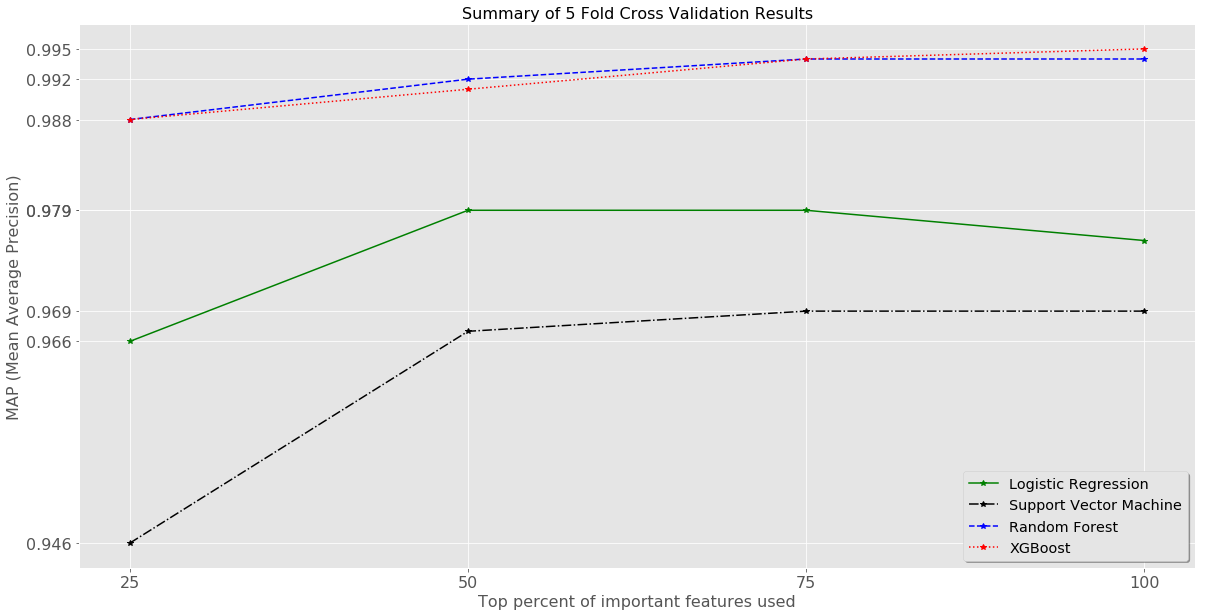

In [113]:
fig, ax = plt.subplots(figsize=(20, 10))
#fig.figure(figsize=(20, 10))
ax.plot([25, 50, 75, 100], [lr25, lr50, lr75, lr100], 
        'k', color='green', marker='*', label='Logistic Regression')
ax.plot([25, 50, 75, 100], [svm25, svm50, svm75, svm100], 
        'k-.', marker='*', label='Support Vector Machine')
ax.plot([25, 50, 75, 100], [rf25, rf50, rf75, rf100], 
        'k--', color='blue', marker='*', label='Random Forest')
ax.plot([25, 50, 75, 100], [xgb25, xgb50, xgb75, xgb100], 
        'k:', color='red', marker='*', label='XGBoost')
ax.set_xticks([25, 50, 75, 100])
ax.set_yticks([svm25, lr25, svm75, lr50, lr75, rf25, rf50, xgb100])
ax.set_title('Summary of 5 Fold Cross Validation Results', fontsize=16)
ax.set_xlabel('Top percent of important features used', fontsize=16)
ax.set_ylabel('MAP (Mean Average Precision)', fontsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.grid(b=True)

The results of Random Forest and XGBoost are near identical, however XGBoost performs slightly better than Random Forest when selecting all features and also has a faster runtime, and for that reason we'll go ahead and use it as the final model to predict the test data.

## Final Results on Test Data and Conclusion

Test MAP: 0.959


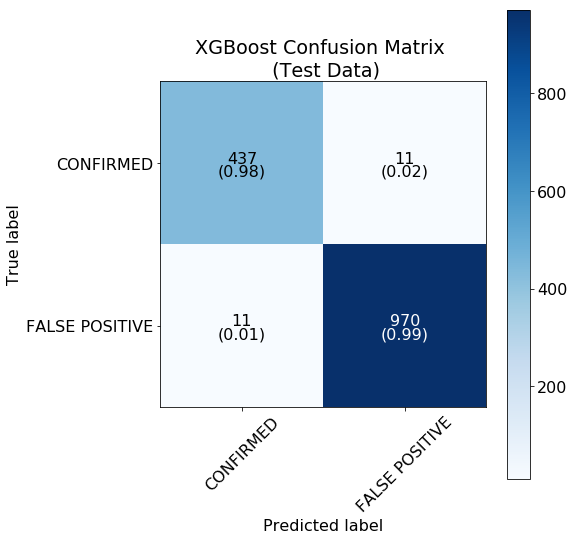

In [110]:
y_pred = xgb_cv100.predict(X_test)
print('Test MAP: {:.3f}'.format(average_precision_score(y_test, y_pred)))

cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])
plot_confusion_matrix(cnf_matrix, 
                      classes=['CONFIRMED','FALSE POSITIVE'],
                      title='XGBoost Confusion Matrix \n (Test Data)')

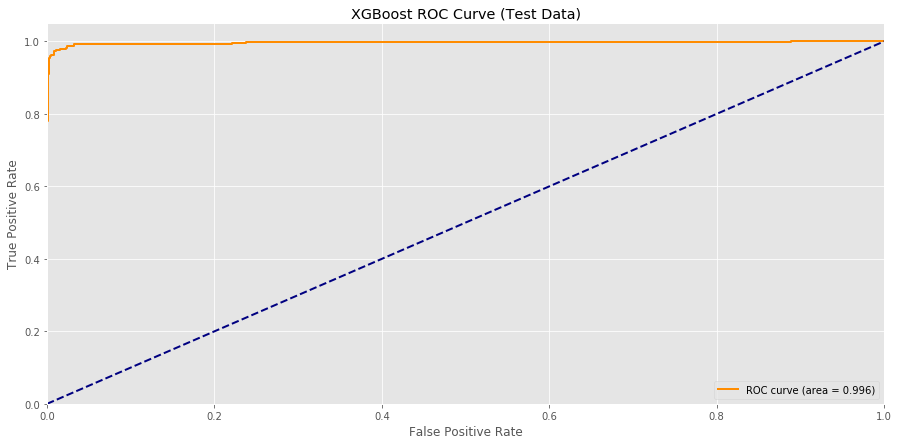

In [111]:
y_pred_prob = xgb_cv100.predict_proba(X_test)

plt.style.use('ggplot')

fpr, tpr, _ = roc_curve(LabelBinarizer().fit_transform(y_test), y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Test Data)')
plt.legend(loc="lower right")
plt.show()

The final MAP score for XGBoost on the testing data was 0.959, only 0.036 decrease from the training MAP score. The ROC AUC score on the test data of 0.996 means that there is a 99.6\% chance that the model will be able to distinguish between a confirmed exoplanet and a false positive. The confusion matrix shows that 11 out of 448, or 2% of confirmed exoplanets were mis-predicted as false positives, and 11 out of 981, or just 1% false positives were mis-predicted as confirmed, showing that the model is slightly better at predicting false positives than confirmed exoplanets. This makes sense as there are nearly twice as many more false positives to train the data on as there are confirmed exoplanets.